In [1]:
import PIL.Image
from osgeo import gdal
import numpy as np
import matplotlib.pylab as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
FILENAME = f"NOAA/data/20230928/GUST/GUST.gfs.t12z.pgrb2.0p25.f000"
dataset = gdal.Open(FILENAME, gdal.GA_ReadOnly)

Description: 0[-] SFC="Ground or water surface"
Min: 0.007, Max:29.307
Origin: (-180.125, 90.125)
Pixel Size: (0.25, -0.25)


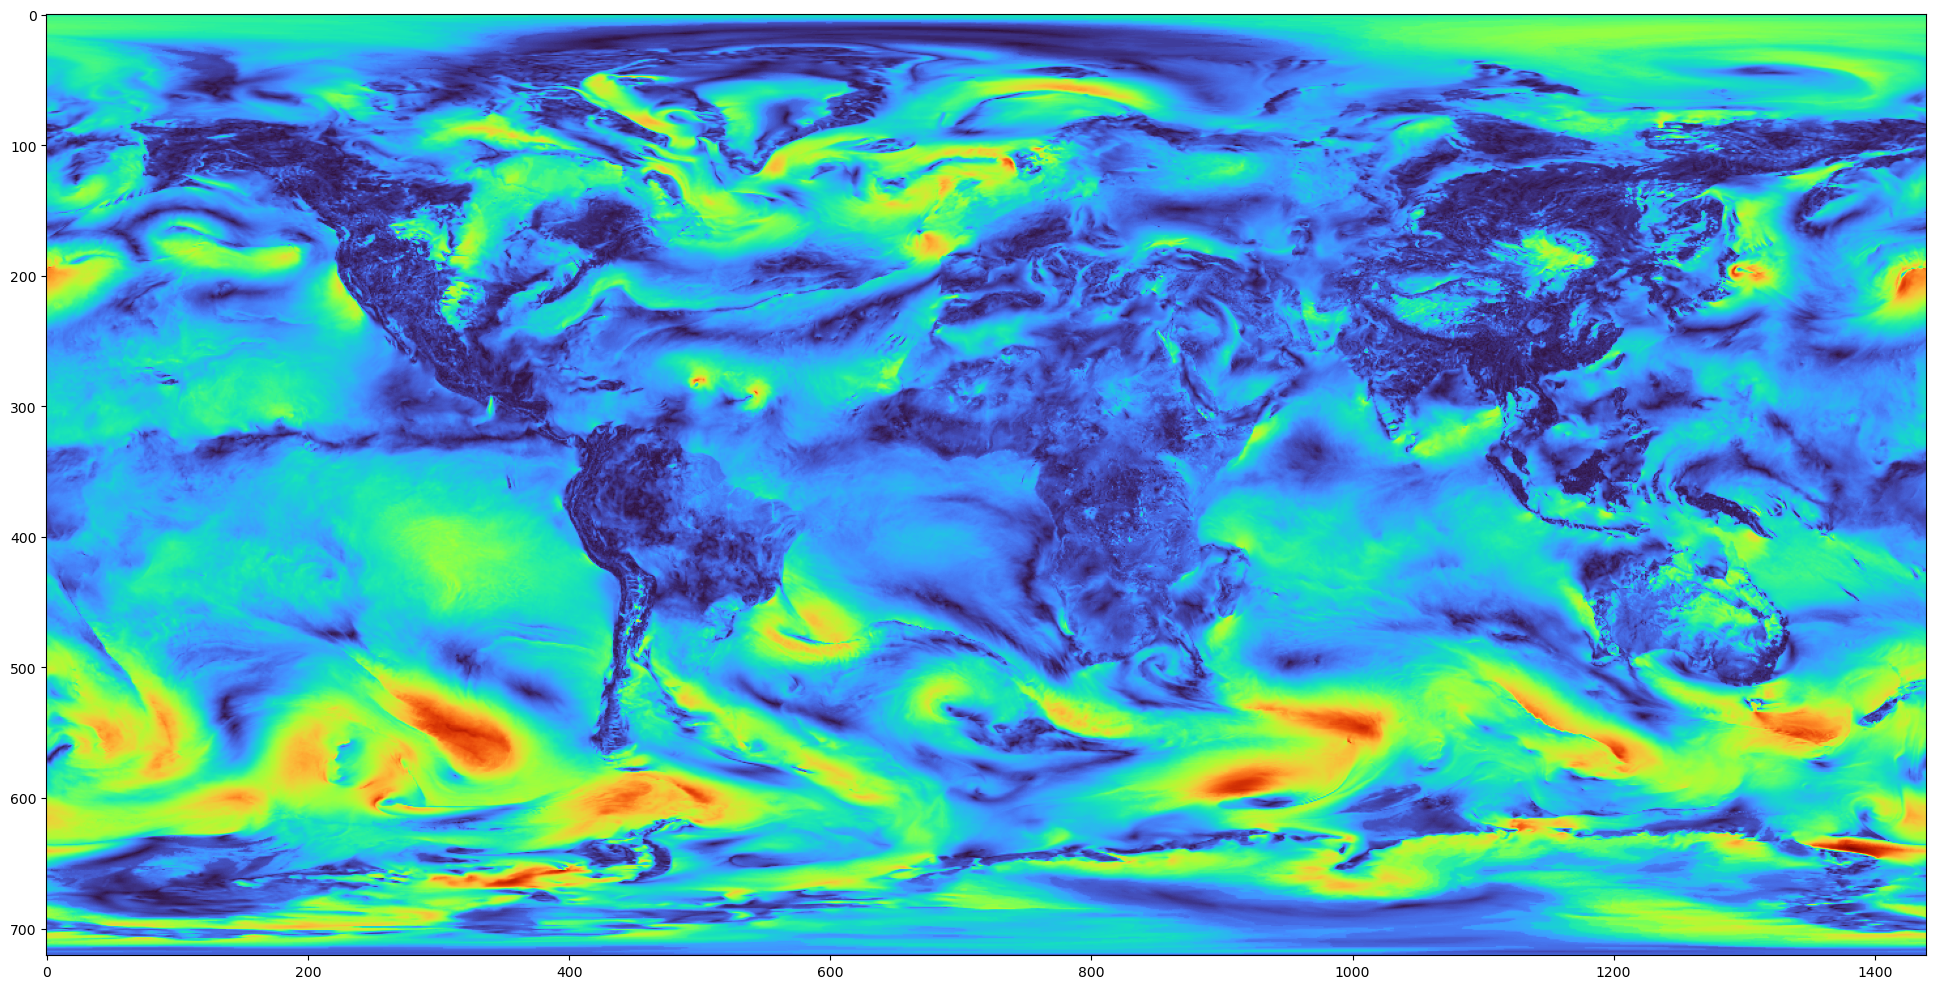

In [10]:
band = dataset.GetRasterBand(1)
print(f"Description: {band.GetDescription()}")

b_min = band.GetMinimum()
b_max = band.GetMaximum()
(b_min, b_max) = band.ComputeRasterMinMax(True)
print(f"Min: {b_min:.3f}, Max:{b_max:.3f}")

geotransform = dataset.GetGeoTransform()
print(f"Origin: ({geotransform[0]}, {geotransform[3]})")
print(f"Pixel Size: ({geotransform[1]}, {geotransform[5]})")

plt.figure(figsize=(20, 10))
plt.imshow(band.ReadAsArray(), 'turbo')
plt.tight_layout()

---

In [4]:
os_map = PIL.Image.open("NOAA/data/NE1_50M_SR_W.png").resize((1440, 721))
os_map = np.array(os_map, dtype=float) / 255.0

In [5]:
UGRD = gdal.Open(f"NOAA/data/20230928/UGRD/UGRD.gfs.t12z.pgrb2.0p25.f000", gdal.GA_ReadOnly)
VGRD = gdal.Open(f"NOAA/data/20230928/VGRD/VGRD.gfs.t12z.pgrb2.0p25.f000", gdal.GA_ReadOnly)
GUST = gdal.Open(f"NOAA/data/20230928/GUST/GUST.gfs.t12z.pgrb2.0p25.f000", gdal.GA_ReadOnly)

In [6]:
subsample_factor = 10

In [7]:
wind_speed = np.flip(np.array(GUST.GetRasterBand(1).ReadAsArray()), axis=0)
wind_speed /= np.max(wind_speed) # Normalise
wind_speed = wind_speed[::subsample_factor, ::subsample_factor]

(None, None)

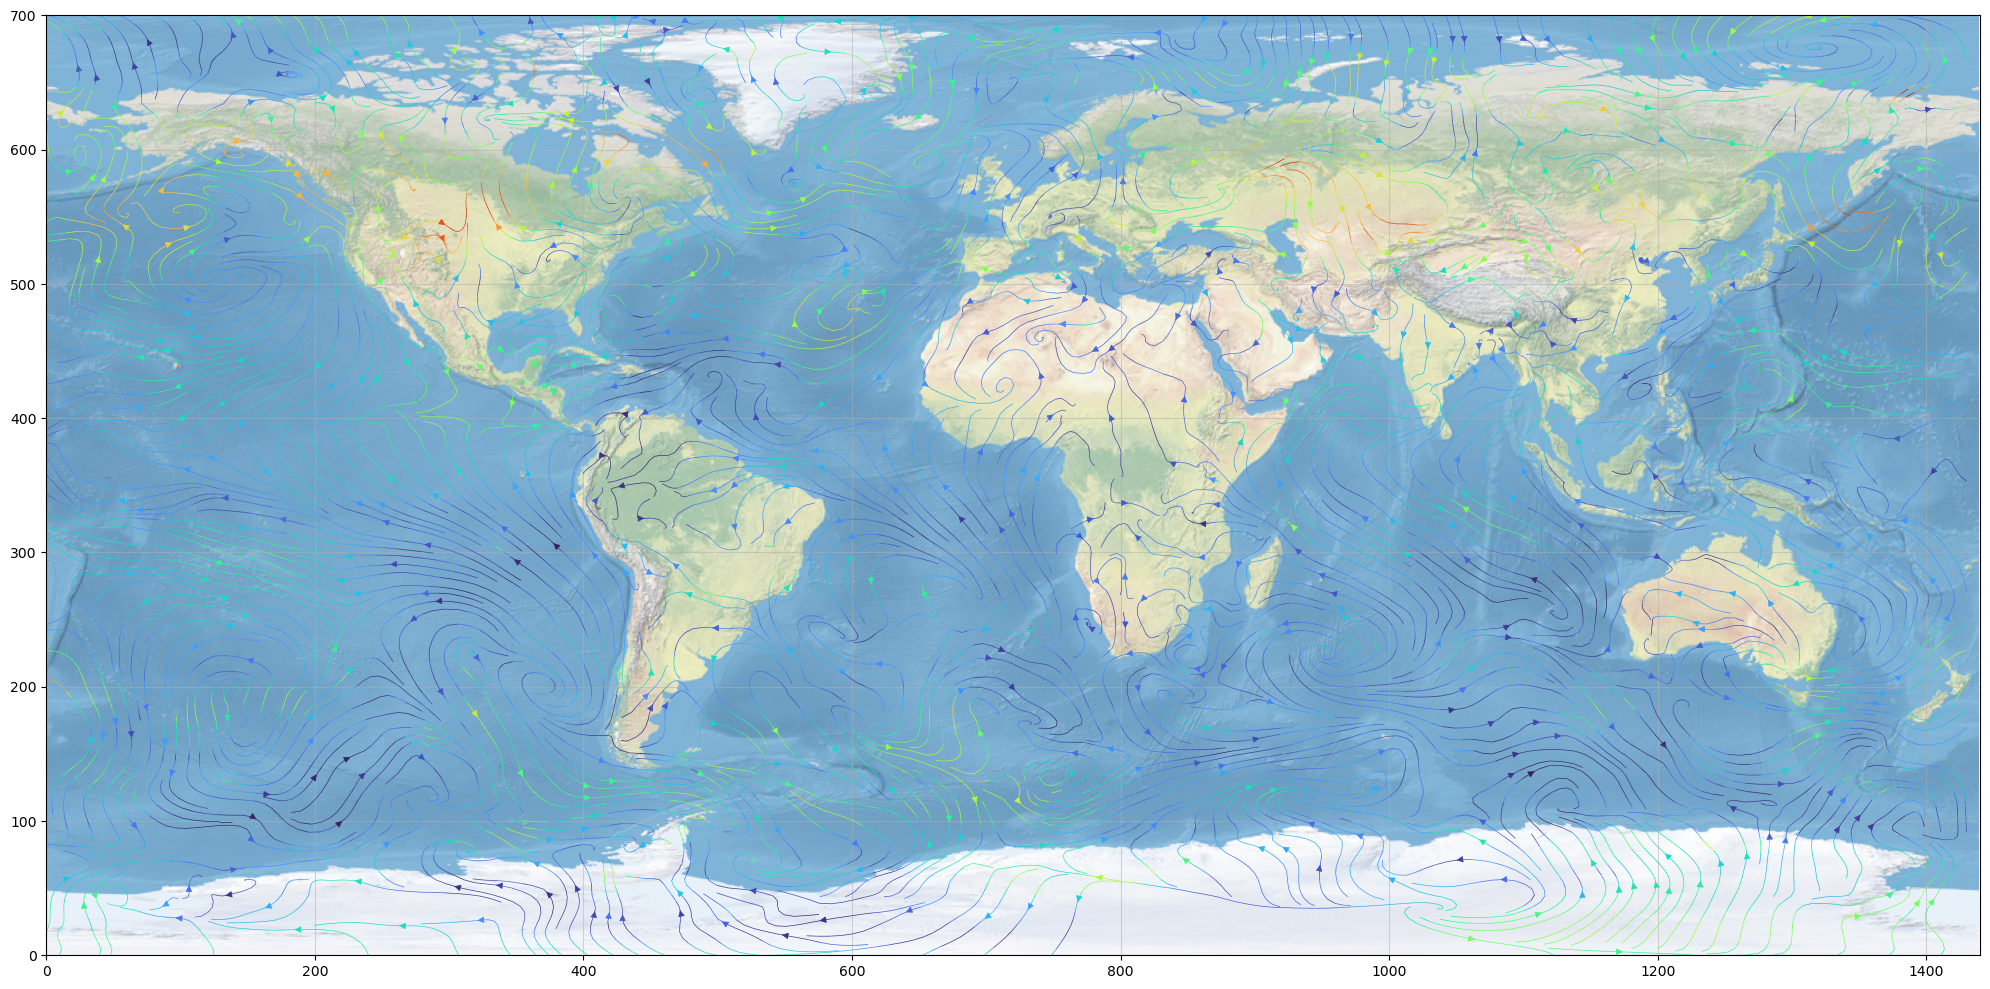

In [8]:
uv_x = np.flip(np.array(UGRD.GetRasterBand(1).ReadAsArray()), axis=0)
uv_y = np.flip(np.array(VGRD.GetRasterBand(1).ReadAsArray()), axis=0)

X, Y = np.meshgrid(np.arange(0, uv_x.shape[1]), np.arange(0, uv_x.shape[0]))

plt.figure(figsize=(20, 10))
plt.imshow(np.flip(os_map, axis=0))
plt.streamplot(X[::subsample_factor, ::subsample_factor],
               Y[::subsample_factor, ::subsample_factor],
               uv_x[::subsample_factor, ::subsample_factor],
               uv_y[::subsample_factor, ::subsample_factor],
               density=5, linewidth=0.5,
               color=np.flip(wind_speed, axis=0),
               cmap='turbo')

plt.xlim(0, 1440), plt.ylim(0, 700)
plt.grid(alpha=0.5), plt.tight_layout()